In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import Float, Array, PRNGKeyArray, jaxtyped
from beartype import beartype as typechecker
import optax
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import powerbox as pbox

from transformer_flow import TransformerFlow

/Users/Jed.Homer/phd/random/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


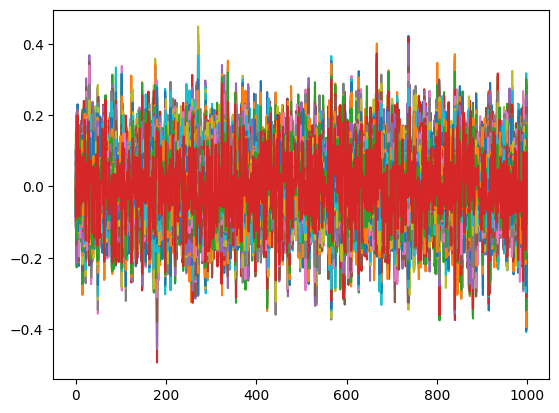

In [2]:
n_data = 1000
n_pix = 64

X = jnp.zeros((n_data, n_pix))
for i in range(n_data):
    pb = pbox.PowerBox(
        N=n_pix,                  
        dim=1,
        pk=lambda k: 0.1*k**-2., 
        boxlength=1.0,
        seed=i
    )
    X = X.at[i].set(pb.delta_x())

plt.figure()
plt.plot(X)
plt.show()

In [3]:
p = 2
s = n_pix // p
rearrange(X[0], "(s p) -> s p", s=s, p=p).shape

(32, 2)

In [4]:
class TransformerFlow1D(TransformerFlow):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def patchify(self, x: Float[Array, "d"]) -> Float[Array, "s p"]:
        s = int(self.img_size / self.patch_size)
        p = self.patch_size
        return rearrange(x, "(s p) -> s p", s=s, p=p)

    def unpatchify(self, x):
        s = int(self.img_size / self.patch_size)
        p = self.patch_size
        return rearrange(x, "s p -> (s p)", s=s, p=p)

key = jr.key(0)

TransformerFlow1D(
    in_channels=1,
    img_size=n_pix,
    patch_size=2,
    channels=128,
    n_blocks=2,
    layers_per_block=2,
    key=key
)

TypeCheckError: Type-check error whilst checking the parameters of transformer_flow.Permutation.__init__.
The problem arose whilst typechecking parameter 'permute'.
Actual value: bool[]
Expected type: <class 'Int[Array, '']'>.
----------------------
Called with parameters: {'self': Permutation(...), 'permute': bool[], 'sequence_length': 1024}
Parameter annotations: (self, permute: Int[Array, ''], sequence_length: int) -> Any.


In [ ]:
from typing import Optional
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


class TimestepEmbedder(nn.Module):
    def __init__(
        self, 
        hidden_size: int, 
        frequency_embedding_size: int = 256
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(
        t: torch.Tensor, 
        dim: int, 
        max_period: int = 10000
    ) -> torch.Tensor:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half) / half
        ).to(t.device)
        args = t[:, None] * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_freq = t_freq.to(dtype=next(self.parameters()).dtype)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    def __init__(
        self, 
        num_classes: int, 
        hidden_size: int, 
        dropout_prob: float
    ):
        super().__init__()
        use_cfg_embedding = int(dropout_prob > 0)
        self.embedding_table = nn.Embedding(
            num_classes + use_cfg_embedding, hidden_size
        )
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(
        self, 
        labels: torch.Tensor, 
        force_drop_ids: torch.Tensor = None
    ) -> torch.Tensor:
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0]) < self.dropout_prob
            drop_ids = drop_ids.cuda()
            drop_ids = drop_ids.to(labels.device)
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(
        self, 
        labels: torch.Tensor, 
        train: bool, 
        force_drop_ids: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


class Attention(nn.Module):
    def __init__(
        self, 
        dim: int, 
        n_heads: int
    ):
        super().__init__()

        self.n_heads = n_heads
        self.n_rep = 1
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, self.n_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, self.n_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)

        self.q_norm = nn.LayerNorm(self.n_heads * self.head_dim)
        self.k_norm = nn.LayerNorm(self.n_heads * self.head_dim)

    @staticmethod
    def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        ndim = x.ndim
        assert 0 <= 1 < ndim
        # assert freqs_cis.shape == (x.shape[1], x.shape[-1])
        _freqs_cis = freqs_cis[: x.shape[1]]
        shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
        return _freqs_cis.view(*shape)

    @staticmethod
    def apply_rotary_emb(
        xq: torch.Tensor, 
        xk: torch.Tensor, 
        freqs_cis: torch.Tensor
    ) -> torch.Tensor:
        xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
        xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))

        freqs_cis_xq = Attention.reshape_for_broadcast(freqs_cis, xq_)
        freqs_cis_xk = Attention.reshape_for_broadcast(freqs_cis, xk_) # self?

        xq_out = torch.view_as_real(xq_ * freqs_cis_xq).flatten(3)
        xk_out = torch.view_as_real(xk_ * freqs_cis_xk).flatten(3)

        return xq_out, xk_out

    def forward(self, x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
        bsz, seqlen, _ = x.shape

        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        dtype = xq.dtype

        xq = self.q_norm(xq)
        xk = self.k_norm(xk)

        xq = xq.view(bsz, seqlen, self.n_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_heads, self.head_dim)

        xq, xk = self.apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)
        xq, xk = xq.to(dtype), xk.to(dtype)

        output = F.scaled_dot_product_attention(
            xq.permute(0, 2, 1, 3),
            xk.permute(0, 2, 1, 3),
            xv.permute(0, 2, 1, 3),
            dropout_p=0.0,
            is_causal=False,
        ).permute(0, 2, 1, 3)
        output = output.flatten(-2)

        return self.wo(output)


class FeedForward(nn.Module):
    def __init__(
        self, 
        dim: int, 
        hidden_dim: int, 
        multiple_of: int, 
        ffn_dim_multiplier: Optional[int] = None
    ):
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        if ffn_dim_multiplier:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)

    def _forward_silu_gating(self, x1: torch.Tensor, x3: torch.Tensor) -> torch.Tensor:
        return F.silu(x1) * x3

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(self._forward_silu_gating(self.w1(x), self.w3(x)))


class TransformerBlock(nn.Module):
    def __init__(
        self,
        layer_id, # Not necessary?
        dim: int,
        n_heads: int,
        multiple_of: int,
        ffn_dim_multiplier: int,
        norm_eps: float,
    ):
        super().__init__()
        self.dim = dim
        self.head_dim = dim // n_heads
        self.attention = Attention(dim, n_heads)
        self.feed_forward = FeedForward(
            dim=dim,
            hidden_dim=4 * dim,
            multiple_of=multiple_of,
            ffn_dim_multiplier=ffn_dim_multiplier,
        )
        self.layer_id = layer_id
        self.attention_norm = nn.LayerNorm(dim, eps=norm_eps)
        self.ffn_norm = nn.LayerNorm(dim, eps=norm_eps)

        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(min(dim, 1024), 6 * dim, bias=True),
        )

    def forward(
        self, 
        x: torch.Tensor, 
        freqs_cis: torch.Tensor, 
        adaln_input: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        if adaln_input is not None:
            shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = (
                self.adaLN_modulation(adaln_input).chunk(6, dim=1)
            )

            x = x + gate_msa.unsqueeze(1) * self.attention(
                modulate(self.attention_norm(x), shift_msa, scale_msa), freqs_cis
            )
            x = x + gate_mlp.unsqueeze(1) * self.feed_forward(
                modulate(self.ffn_norm(x), shift_mlp, scale_mlp)
            )
        else:
            x = x + self.attention(self.attention_norm(x), freqs_cis)
            x = x + self.feed_forward(self.ffn_norm(x))

        return x


class FinalLayer(nn.Module):
    def __init__(
        self, 
        hidden_size: int, 
        patch_size: int, 
        out_channels: int
    ):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(
            hidden_size, patch_size * patch_size * out_channels, bias=True
        )
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(min(hidden_size, 1024), 2 * hidden_size, bias=True),
        )
        nn.init.constant_(self.linear.weight, 0.)
        nn.init.constant_(self.linear.bias, 0.)

    def forward(
        self, 
        x: torch.Tensor, 
        c: torch.Tensor
    ) -> torch.Tensor:
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT_Llama(nn.Module):
    def __init__(
        self,
        in_channels=3,
        input_size=32,
        patch_size=2,
        dim=512,
        n_layers=5,
        n_heads=16,
        multiple_of=256,
        ffn_dim_multiplier=None,
        norm_eps=1e-5,
        class_dropout_prob=0.1,
        num_classes=10,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = in_channels
        self.input_size = input_size
        self.patch_size = patch_size

        self.init_conv_seq = nn.Sequential(
            nn.Conv2d(in_channels, dim // 2, kernel_size=5, padding=2, stride=1),
            nn.SiLU(),
            nn.GroupNorm(32, dim // 2),
            nn.Conv2d(dim // 2, dim // 2, kernel_size=5, padding=2, stride=1),
            nn.SiLU(),
            nn.GroupNorm(32, dim // 2),
        )

        self.x_embedder = nn.Linear(patch_size * patch_size * dim // 2, dim, bias=True)
        nn.init.constant_(self.x_embedder.bias, 0.)

        self.t_embedder = TimestepEmbedder(min(dim, 1024))
        self.y_embedder = LabelEmbedder(num_classes, min(dim, 1024), class_dropout_prob)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    layer_id,
                    dim,
                    n_heads,
                    multiple_of,
                    ffn_dim_multiplier,
                    norm_eps,
                )
                for layer_id in range(n_layers)
            ]
        )
        self.final_layer = FinalLayer(dim, patch_size, self.out_channels)

        self.freqs_cis = DiT_Llama.precompute_freqs_cis(dim // n_heads, 4096)

    def unpatchify(self, x):
        c = self.out_channels
        p = self.patch_size
        h = w = int(x.shape[1] ** 0.5)
        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum("nhwpqc->nchpwq", x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def patchify(self, x):
        B, C, H, W = x.size()
        x = x.view(
            B,
            C,
            H // self.patch_size,
            self.patch_size,
            W // self.patch_size,
            self.patch_size,
        )
        x = x.permute(0, 2, 4, 1, 3, 5).flatten(-3).flatten(1, 2)
        return x

    def forward(self, x, t, y):
        self.freqs_cis = self.freqs_cis.to(x.device)

        x = self.init_conv_seq(x)

        x = self.patchify(x)
        x = self.x_embedder(x)

        t = self.t_embedder(t)  # (N, D)
        y = self.y_embedder(y, self.training)  # (N, D)
        adaln_input = t.to(x.dtype) + y.to(x.dtype)

        for layer in self.layers:
            x = layer(x, self.freqs_cis[: x.size(1)], adaln_input=adaln_input)

        x = self.final_layer(x, adaln_input)
        x = self.unpatchify(x)  # (N, out_channels, H, W)

        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        eps, rest = model_out[:, : self.in_channels], model_out[:, self.in_channels :]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

    @staticmethod
    def precompute_freqs_cis(dim, end, theta=10000.0):
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        t = torch.arange(end)
        freqs = torch.outer(t, freqs).float()
        freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
        return freqs_cis


if __name__ == "__main__":
    model = DiT_Llama(patch_size=2, dim=256, n_layers=16, n_heads=32)
    model.eval()
    x = torch.randn(2, 3, 32, 32)
    t = torch.randint(0, 100, (2,))
    y = torch.randint(0, 10, (2,))

    with torch.no_grad():
        out = model(x, t, y)
        print(out.shape)
        out = model.forward_with_cfg(x, t, y, 0.5)
        print(out.shape)

torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 32, 32])
